In [949]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Data Preparation

In [950]:
df_pops = pd.read_pickle('./populations.pkl')
df_china = df_pops[df_pops['NGA']=='Middle Yellow River Valley'].sort_values('From_Year')
# Max values for populaiton estimates and 'to_year' are removed for simplicity and because most of them are not specified anyway.
df_china.drop(['To_Year', 'Pop_Max', 'NGA'], axis=1, inplace=True)
df_china.rename({'Pop_Min': 'Population', 'From_Year': 'Year'}, axis=1, inplace=True)

In [1010]:
df_china.shape

(37, 2)

<AxesSubplot:title={'center':'Population of Middle Yellow River Valley Through History'}, xlabel='Year', ylabel='Population'>

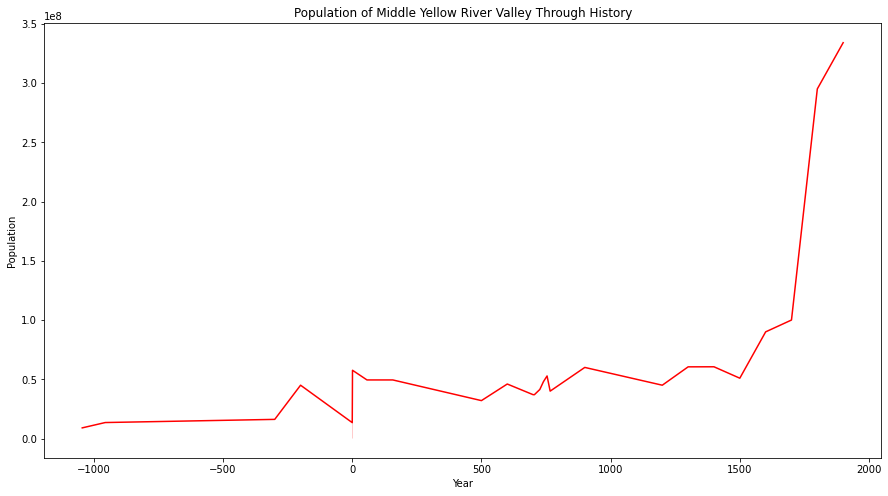

In [951]:
plt.figure(figsize=(15,8))
plt.title('Population of Middle Yellow River Valley Through History')
sns.lineplot(data=df_china, x='Year', y='Population', color='red')

<AxesSubplot:ylabel='Frequency'>

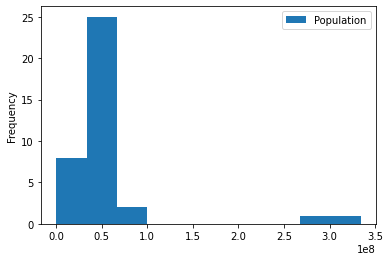

In [952]:
df_china.plot.hist(x='Year')

<AxesSubplot:ylabel='Density'>

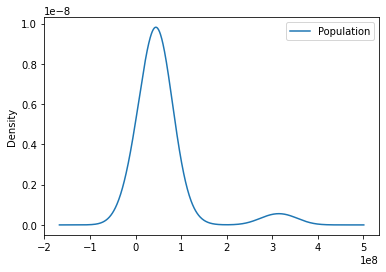

In [953]:
df_china.plot.kde(x='Year')

<AxesSubplot:>

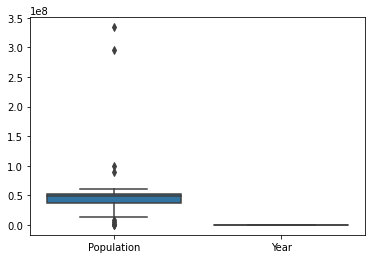

In [1006]:
sns.boxplot(data=df_china)

### Model Selection

In [954]:
X=df_china[['Year']]
y=df_china['Population']

In [955]:
estimators=[('ridgecv', RidgeCV()), ('lassocv', LassoCV()), ('lr', LinearRegression()), ('elasticcv', ElasticNetCV())]

In [956]:
#format: (<estimator name>, <parameters>, <score>)
scores = []
for estimator in estimators:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
    for degree in range(10):
        pipe = make_pipeline(PolynomialFeatures(degree=degree), estimator[1])
        pipe.fit(X_train, y_train)
        scores.append( (estimator[0], degree, pipe.score(X_test, y_test)) )

In [957]:
df_scores = pd.DataFrame(scores, columns=['Estimator', 'Degree', 'Score'])
df_scores.set_index('Estimator', inplace=True)

In [958]:
df_scores.groupby('Estimator').max()

,Degree,Score
Estimator,,
elasticcv,9,0.836564
lassocv,9,0.836564
lr,9,0.848471
ridgecv,9,0.566750


In [959]:
df_scores.sort_values('Score', ascending=False).head()

,Degree,Score
Estimator,,
lr,4,0.848471
lr,5,0.846688
elasticcv,7,0.836564
lassocv,7,0.836564
elasticcv,8,0.832443


RidgeCV performs extremely badly and therefore will be removed from consideration.

Text(0.5, 1.0, 'Scores Comparison')

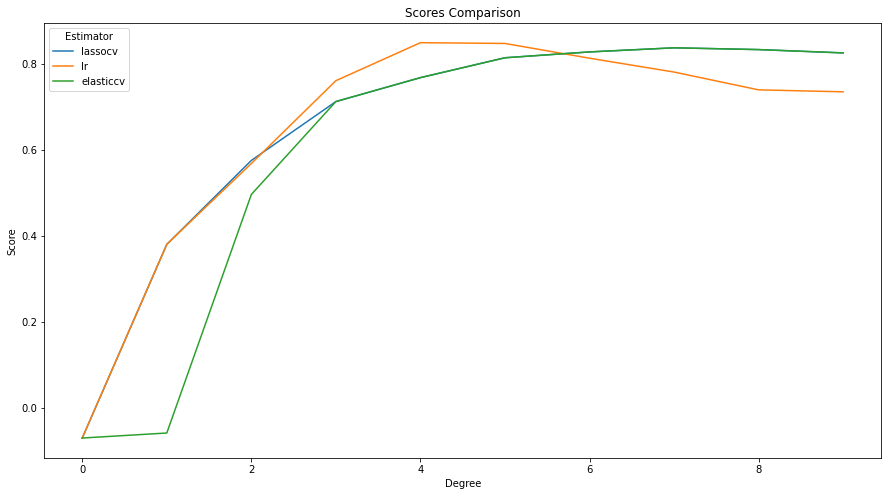

In [960]:
plt.figure(figsize=(15,8))
sns.lineplot(data=df_scores.drop('ridgecv'), x='Degree', y='Score', hue='Estimator').set_title('Scores Comparison')

Best score belongs to vanilla Linear with polynomial features of 4th degree.

In [961]:
pipe=make_pipeline(PolynomialFeatures(degree=4), LinearRegression(normalize=True)).fit(X_train, y_train)
yhat=pipe.predict(X)
print('LinearReg: {}'.format(pipe.score(X, y)))

LinearReg: 0.8660258677831475


Text(0.5, 1.0, 'Vanilla Linear')

<Figure size 1080x576 with 0 Axes>

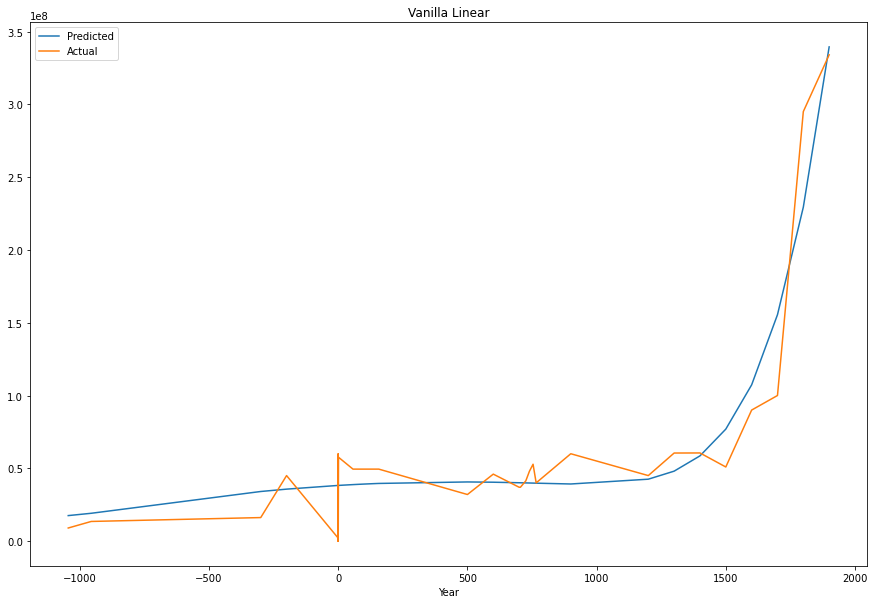

In [1003]:
plt.figure(figsize=(15,8))
pd.DataFrame({'Predicted': yhat, 'Actual': y, 'Year': X['Year']}).plot(x='Year', figsize=(15, 10)).set_title('Vanilla Linear')

Let's now see if LassoCV performance can be improved with parameters tuning:

In [963]:
pipe=make_pipeline(PolynomialFeatures(degree=8), LassoCV(normalize=True, cv=5, max_iter=10000)).fit(X_train, y_train)
yhat=pipe.predict(X)
print('LassoCV: {}'.format(pipe.score(X, y)))

LassoCV: 0.8853916955340185


Text(0.5, 1.0, 'LassoCV')

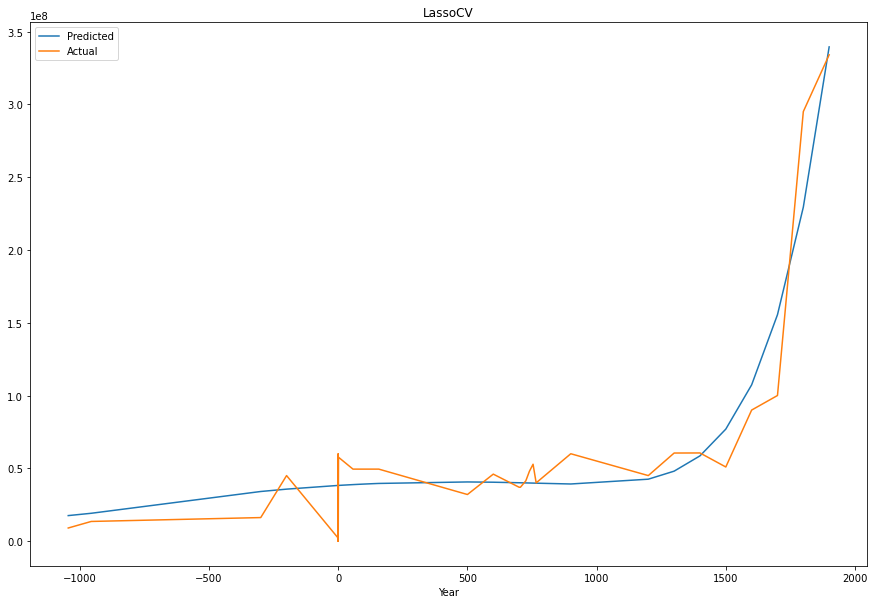

In [1001]:
pd.DataFrame({'Predicted': yhat, 'Actual': y, 'Year': X['Year']}).plot(x='Year'c.set_title('LassoCV')

## Regularization

In [965]:
scores=[]
alphas = np.geomspace(0.001, 0.1, 10)
ts = np.linspace(0.1, 0.6, 5)

for alpha in alphas:
    for test_size in ts:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
        pipe=make_pipeline(PolynomialFeatures(degree=8), LassoCV(normalize=True, cv=5, max_iter=100000)).fit(X_train, y_train)
        scores.append((alpha, test_size, pipe.score(X, y)))

In [966]:
df_scores=pd.DataFrame(scores, columns=['Alpha', 'Test Size', 'Score'])

<AxesSubplot:xlabel='Test Size', ylabel='Score'>

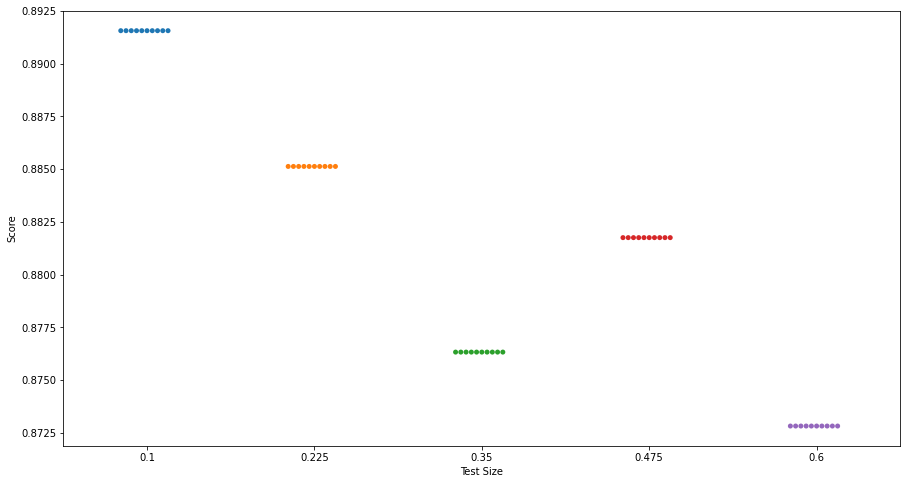

In [967]:
plt.figure(figsize=(15,8))
sns.swarmplot(data=df_scores, x='Test Size', y='Score')

<AxesSubplot:xlabel='Alpha', ylabel='Score'>

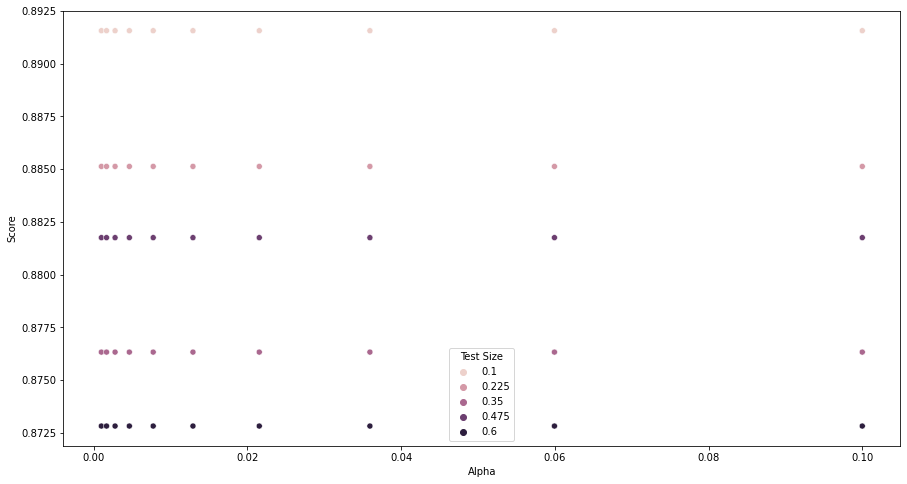

In [1007]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_scores, x='Alpha', y='Score', hue='Test Size')

## Final Model

In [969]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 
pipe=make_pipeline(PolynomialFeatures(degree=8), LassoCV(normalize=True, cv=5, max_iter=100000)).fit(X_train, y_train)
yhat=pipe.predict(X)
print('LassoCV: {}'.format(pipe.score(X, y)))

LassoCV: 0.8915651269911424


Text(0.5, 1.0, 'Population Prediction - LassoCV')

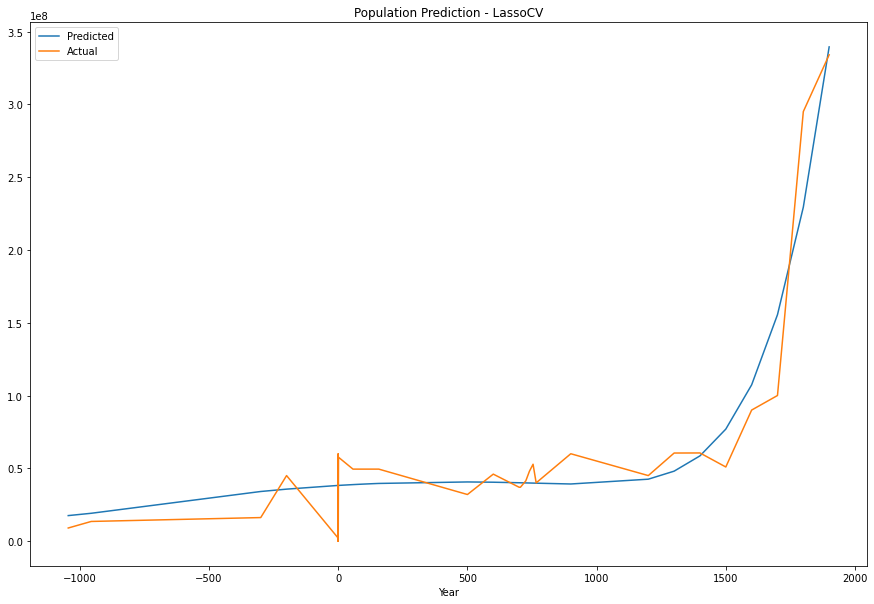

In [1008]:
pd.DataFrame({'Predicted': yhat, 'Actual': y, 'Year': X['Year']}).plot(x='Year', figsize=(15, 10)).set_title('Population Prediction - LassoCV')